# Text Mining with Sklearn



__Author:__ Colin Cambo

__Date:__ 4/10/2017

__About:__ This notebook is a lecture on text mining with sklearn that will be given to the UNH Analytics 2016-2017 cohort.

__Contents:__

  * [0 Introduction 20 newsgroups Dataset](#0)
    * [0.1 Loading Data](#0.1)
    * [0.2 Simple Exploration](#0.2)
  * [1 Text Mining Basics](#1)
    * [1.1 CountVectorizer](#1.1)
        * [1.1.1 Description](#1.1.1)
        * [1.1.2 Example](#1.1.2)
        * [1.1.3 Parameters](#1.1.3)
          * [1.1.3.1 min_df](#1.1.3.1)
          * [1.1.3.2 max_df](#1.1.3.2)
          * [1.1.3.3 ngram_range](#1.1.3.3)
          * [1.1.3.4 max_features](#1.1.3.4)
    * [1.2 TfidfTransformer](#1.2)
      * [1.2.1 Description](#1.2.1)
      * [1.2.2 Example](#1.2.2)
      * [1.2.3 Parameters](#1.2.3)
          * [1.2.3.1 norm](#1.2.3.1)
          * [1.2.3.2 use_idf](#1.2.3.2)
  * [2 Modeling](#2)
    * [2.1 Multinomial Naive Bayes](#2.1)
      * [2.1.1 Description](#2.1.1)
      * [2.1.2 Example](#2.1.2)
      * [2.1.3 Parameters](#2.1.3)
        * [2.1.3.1 alpha](#2.1.3.1)
    * [2.2 Stochastic Gradient Descent](#2.2)
      * [2.2.1 Description](#2.2.1)
      * [2.2.2 Example](#2.2.2)
      * [2.2.3 Parameters](#2.2.3)
        * [2.2.3.1 alpha](#2.2.3.1)
        * [2.2.3.2 epsilon](#2.2.3.2)
  * [3 Tuning Models](#3)
    * [3.1 Pipelines](#3.1)
      * [3.1.1 Description](#3.1.1)
      * [3.1.2 Example](#3.1.2)
    * [3.2 Parameter Seach](#3.2)
      * [3.2.1 GridSearchCV](#3.2.1)
        * [3.2.1.1 Description](#3.2.1)
        * [3.2.1.2 Example](#3.2.2)
        * [3.2.1.3 Parameters](#3.2.3)
      * [3.2.1 RandomizedSearchCV](#3.2.1)
        * [3.2.1.1 Description](#3.2.1)
        * [3.2.1.2 Example](#3.2.2)
        * [3.2.1.3 Parameters](#3.2.3)
  * [4 Increasing Performance](#4)
    * [4.1 Stemming](#4.1)
      * [4.1.1 Description](#4.1.1)
      * [4.1.2 Example](#4.1.2)
      * [4.1.3 Types](#4.1.3)
        * [2.2.3.1 Porter](#4.1.3.1)
        * [2.2.3.1 Lancaster](#4.1.3.2)
        * [4.1.3.3 Snowball](#4.1.3.3)
    * [4.2 Custom Transformers](#4.2)
      * [4.2.1 ColSelector](#4.2.1)
        
__Requirements__

Run the cell below to pip install all dependencies

In [ ]:
#!pip install -r requirements.txt

In [322]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier
from ipywidgets import interact
from time import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

<a id='0'></a>
# 0 Introduction 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

For more information about the data: http://qwone.com/~jason/20Newsgroups/

<a id='0.1'></a>
## 0.1 Loading Data

We will use sklearn to load the data, so we will import the function fetch_20newsgroups from sklearn.datasets

In [2]:
from sklearn.datasets import fetch_20newsgroups

The default parameters will return the entire dataset as a python object. Below we will set data equal to the dataset

In [3]:
data = fetch_20newsgroups()

Target names are stored in data.target_names, below are all of the target names currently in our dataset. 

In [4]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Using Counter we can see just how many observations belong to each of our classes

In [5]:
from collections import Counter

In [6]:
Counter(data.target)

Counter({0: 480,
         1: 584,
         2: 591,
         3: 590,
         4: 578,
         5: 593,
         6: 585,
         7: 594,
         8: 598,
         9: 597,
         10: 600,
         11: 595,
         12: 591,
         13: 594,
         14: 593,
         15: 599,
         16: 546,
         17: 564,
         18: 465,
         19: 377})

Overall the dataset is pretty balanced between the classes, which makes classification easier for us, but there are still too many observations for us to effectively model in a short period, so we will subset the dataset by taking only 5 classes.

To subset the dataset by classes you just have to pass a list of the classes you're interested in to the fetch_20newsgroups function's categories variable. We will also subset our dataset to just get the train set.

In [7]:
cat = ['rec.sport.baseball', 'sci.electronics', 'talk.politics.misc', 'sci.crypt', 'misc.forsale']

In [8]:
train = fetch_20newsgroups(subset='train', categories=cat, shuffle=True, random_state=42)

<a id='0.2'></a>
## 0.2 Simple Data Exploration

This lecture is for text mining so our data exploration will be minimal

In [9]:
len(train.data)

2833

In [10]:
len(train.target)

2833

In [11]:
train.target_names

['misc.forsale',
 'rec.sport.baseball',
 'sci.crypt',
 'sci.electronics',
 'talk.politics.misc']

In [12]:
Counter(train.target)

Counter({0: 585, 1: 597, 2: 595, 3: 591, 4: 465})

In [13]:
df = pd.DataFrame({'Text':train.data, 'Target':train.target})

In [14]:
df.head()

,Target,Text
0,0,From: jay@gdx.UUCP (Jay Snyder)\nSubject: WANT...
1,4,From: VEAL@utkvm1.utk.edu (David Veal)\nSubjec...
2,1,From: rickert@NeXTwork.Rose-Hulman.Edu (John H...
3,0,From: rosen@kranz.enet.dec.com (Jim Rosenkranz...
4,0,From: shapiro@oucsace.cs.ohiou.edu (Brian Shap...


In [15]:
print(df.iloc[0]['Text'])

From: jay@gdx.UUCP (Jay Snyder)
Subject: WANTED: avionics equip.
Organization: GDX-BBS,Central Pa Unix BBS/anon uucp (717)737-3249 PEP+/2400/1200 24hrs
Lines: 21


I'm looking for good deals on the following (used or new):
Aviation Headsets (with mic).
Handheld Nav/Com tranciever (may consider COM only).
Portable GPS or Loran Navigator.

Reply here or call:
(717)737-3236 (only after 5pm -- please don't wake the night worker
   in my house).
(717)540-2895 if you must call during the day (I can understand if you
   want your employer to pay for the call).

_______________________________________________________________________________
Jay A. Snyder               jay@gdx         ...{uunet,vogon1}!compnect!gdx!jay
This is your Brain: (unix)              GDX-BBS (717) 737-3249 WorldBlazer
This is your Brain on drugs: (MSDOS)    Unix and MSDOS File areas + Xenix bins
-- 
_______________________________________________________________________________
Jay A. Snyder               jay@gdx       

This isn't your usual text data, so we will see if this still follows Zipf's law

In [181]:
from functools import reduce
import re
token_regex = re.compile('(?u)\\b\\w\\w+\\b')

#Here we're just combining all tokens into one massive string
all_msgs = reduce((lambda x, y: x + y), map(lambda x: token_regex.findall(x.lower()), df['Text'].tolist()))

In [182]:
count = Counter(all_msgs)

In [183]:
#Sorting counts
word_counts = sorted(list(count.items()), key=lambda x:x[1], reverse=True)

In [184]:
#Displaying first 10
word_counts[:10]

[('the', 35118),
 ('to', 18795),
 ('of', 15683),
 ('and', 13647),
 ('in', 11243),
 ('is', 10122),
 ('that', 9305),
 ('it', 7648),
 ('for', 7607),
 ('you', 6014)]

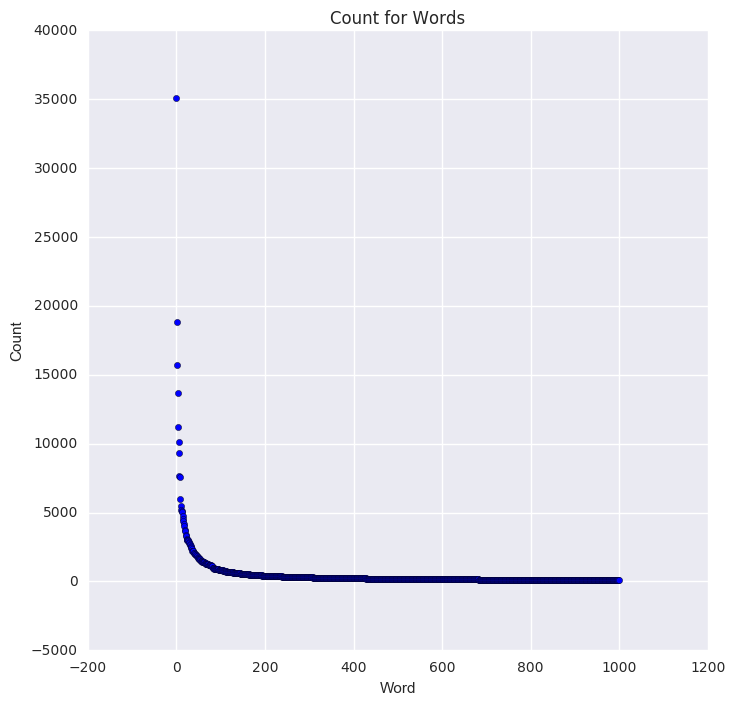

In [185]:
subset_word_counts = word_counts[:1000]
plt.figure(figsize=(8,8))
plt.scatter(x=range(len(subset_word_counts)), y=[w[1] for w in subset_word_counts])
plt.title('Count for Words')
plt.ylabel('Count')
plt.xlabel('Word')

Yup that's Zipf's law

<a id='1'></a>
# 1 sklearn Text Mining Basics

sklearn has many great tools for text mining, in this section we will cover two of the more important ones

<a id='1.1'></a>
## 1.1 CountVectorizer

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors. This is typically done with __Bag-of-Words__, and this is where the CountVectorizer class comes in handy. You can read more about the CountVectorizer [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

<a id='1.1.1'></a>
### 1.1.1 Description

"Convert a collection of text documents to a matrix of token counts

This implementation produces a sparse representation of the counts using scipy.sparse.coo_matrix."

<a id='1.1.2'></a>
### 1.1.2 Example

To get a better understanding of the class we will do an example below

In [21]:
text = ['cat dog dog dog dog dog dog dog', 'cat fish puppy', 'fish cat']

In [22]:
vect = CountVectorizer()

In [23]:
dtm = vect.fit_transform(text)

In [24]:
print(dtm)

  (0, 1)	7
  (0, 0)	1
  (1, 3)	1
  (1, 2)	1
  (1, 0)	1
  (2, 2)	1
  (2, 0)	1


In [25]:
vect.get_feature_names()

['cat', 'dog', 'fish', 'puppy']

In [26]:
df2 = pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

In [27]:
df2

,cat,dog,fish,puppy
0,1,7,0,0
1,1,0,1,1
2,1,0,1,0


In [28]:
def dtm_todf(dtm, vect):
    return pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

In [29]:
dtm_todf(dtm, vect)

,cat,dog,fish,puppy
0,1,7,0,0
1,1,0,1,1
2,1,0,1,0


<a id='1.1.3'></a>
### 1.1.3 Parameters

This class has many parameters but we will highlight a few of the most important ones

<a id='1.1.3.1'></a>
#### 1.1.3.1 min_df

__min_df__ : float in range [0.0, 1.0] or int, default=1

When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

__Example__

We will show what the document term matrix looks like before and after min_df parameter is used

In [30]:
cv = CountVectorizer()

In [31]:
train_dtm = cv.fit_transform(df['Text'])

In [32]:
train_dtm.shape

(2833, 38850)

So the shape of our dtm is (2833, 38850) before using min_df.

Lets see what the shape is after using a min_df of 5

In [33]:
cv = CountVectorizer(min_df=5)

In [34]:
train_dtm = cv.fit_transform(df['Text'])

In [35]:
train_dtm.shape

(2833, 9819)

Too see how the min_df affects the dtm's shape for different values we will number of columns below for a min_df from 1 to 10

min_df=1 has shape (2833, 38850)
min_df=2 has shape (2833, 20541)
min_df=3 has shape (2833, 14609)
min_df=4 has shape (2833, 11662)
min_df=5 has shape (2833, 9819)
min_df=6 has shape (2833, 8508)
min_df=7 has shape (2833, 7561)
min_df=8 has shape (2833, 6797)
min_df=9 has shape (2833, 6160)


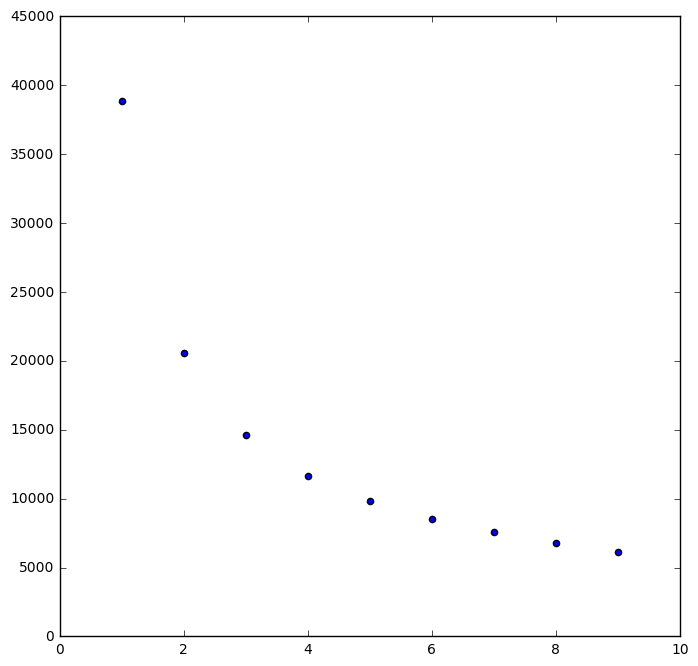

In [36]:
plt.figure(figsize=(8,8))
for min_df in np.arange(1,10,1):
    cv = CountVectorizer(min_df=min_df)
    train_dtm = cv.fit_transform(df['Text'])
    num_cols = train_dtm.shape[1]
    print('min_df={} has shape {}'.format(min_df, train_dtm.shape))
    plt.scatter(min_df, num_cols)

<a id='1.1.3.2'></a>
#### 1.1.3.2 max_df

__max_df :__ float in range [0.0, 1.0] or int, default=1.0

When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

__Example__

We will show what max_df does to the document term matrix

In [37]:
cv = CountVectorizer()
train_dtm = cv.fit_transform(df['Text'])
print("The shape of the dtm with default max_df: {}".format(train_dtm.shape))

The shape of the dtm with default max_df: (2833, 38850)


In [38]:
cv = CountVectorizer(max_df=.5)
train_dtm = cv.fit_transform(df['Text'])
print("The shape of the dtm with .5 max_df: {}".format(train_dtm.shape))

The shape of the dtm with .5 max_df: (2833, 38826)


To view the impact of max_df for different values we will plot the feature space for a range of max_df values

max_df=0.100000 has shape (2833, 38663)
max_df=0.200000 has shape (2833, 38767)
max_df=0.300000 has shape (2833, 38793)
max_df=0.400000 has shape (2833, 38814)
max_df=0.500000 has shape (2833, 38826)
max_df=0.600000 has shape (2833, 38835)
max_df=0.700000 has shape (2833, 38839)
max_df=0.800000 has shape (2833, 38841)
max_df=0.900000 has shape (2833, 38845)


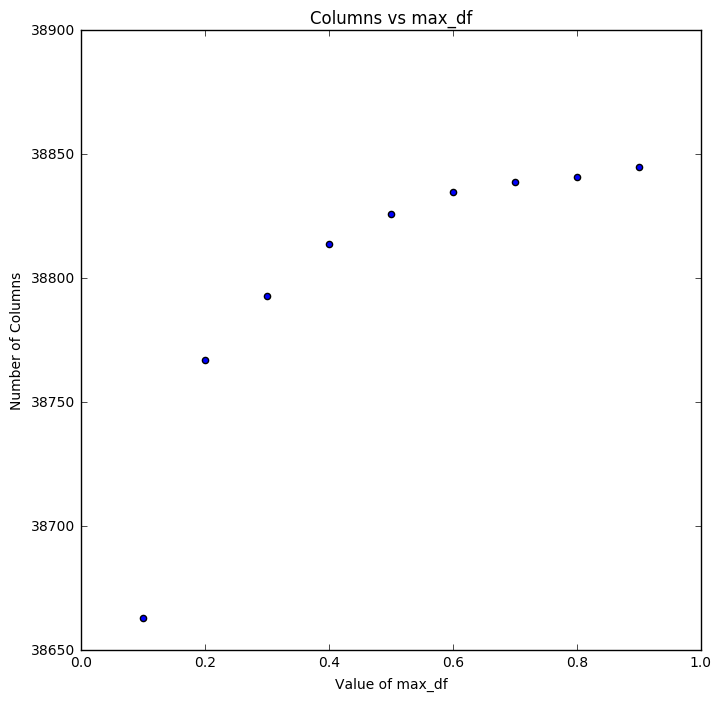

In [39]:
plt.figure(figsize=(8,8))
plt.ylabel('Number of Columns')
plt.xlabel('Value of max_df')
plt.title('Columns vs max_df')
for max_df in np.arange(.1,1.0,.1):
    cv = CountVectorizer(max_df=max_df)
    train_dtm = cv.fit_transform(df['Text'])
    num_cols = train_dtm.shape[1]
    print('max_df={:f} has shape {}'.format(max_df, train_dtm.shape))
    plt.scatter(max_df, num_cols)

max_df=25 has shape (2833, 36397)
max_df=50 has shape (2833, 37560)
max_df=75 has shape (2833, 37997)
max_df=100 has shape (2833, 38231)
max_df=125 has shape (2833, 38365)
max_df=150 has shape (2833, 38447)
max_df=175 has shape (2833, 38519)


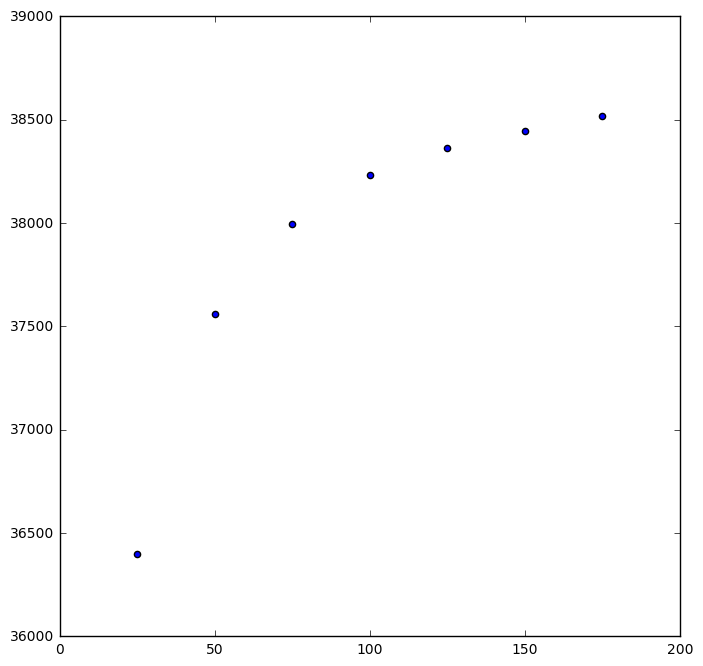

In [40]:
plt.figure(figsize=(8,8))
for max_df in np.arange(25,200,25):
    cv = CountVectorizer(max_df=max_df)
    train_dtm = cv.fit_transform(df['Text'])
    num_cols = train_dtm.shape[1]
    print('max_df={} has shape {}'.format(max_df, train_dtm.shape))
    plt.scatter(max_df, num_cols)

<a id='1.1.3.3'></a>
#### 1.1.3.3 ngram_range

__ngram_range :__ tuple (min_n, max_n)

The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

__Example__

We will show what happens to the document term matrix when different combinations are used

In [41]:
cv = CountVectorizer(ngram_range=(1,1))
train_dtm = cv.fit_transform(df['Text'])
print("The shape of the dtm with ngram_range=(1,1): {}".format(train_dtm.shape))

The shape of the dtm with ngram_range=(1,1): (2833, 38850)


In [42]:
cv = CountVectorizer(ngram_range=(1,2))
train_dtm = cv.fit_transform(df['Text'])
print("The shape of the dtm with ngram_range=(1,2): {}".format(train_dtm.shape))

The shape of the dtm with ngram_range=(1,2): (2833, 331486)


In [43]:
cv = CountVectorizer(ngram_range=(1,3))
train_dtm = cv.fit_transform(df['Text'])
print("The shape of the dtm with ngram_range=(1,3): {}".format(train_dtm.shape))

The shape of the dtm with ngram_range=(1,3): (2833, 823987)


<a id='1.1.3.4'></a>
#### 1.1.3.4 stop_words

__stop_words :__ string {‘english’}, list, or None (default)

If ‘english’, a built-in stop word list for English is used.
If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens. Only applies if analyzer == 'word'.

If None, no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.

__Example__

We will show how removing stop_words affects our document term matrix

In [44]:
cv = CountVectorizer(stop_words=None)
train_dtm = cv.fit_transform(df['Text'])
print("The shape of the dtm with stop_words=None: {}".format(train_dtm.shape))

The shape of the dtm with stop_words=None: (2833, 38850)


In [45]:
cv = CountVectorizer(stop_words='english')
train_dtm = cv.fit_transform(df['Text'])
print("The shape of the dtm with stop_words=None: {}".format(train_dtm.shape))

The shape of the dtm with stop_words=None: (2833, 38546)


<a id='1.1.3.5'></a>
#### 1.1.3.5 max_features

__max_features :__ int or None, default=None

If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

This parameter is ignored if vocabulary is not None.

__Example__

We will show how max_features affects our dtm, and how it interacts with other CountVectorizer parameters

In [46]:
cv = CountVectorizer(max_features=20)
train_dtm = cv.fit_transform(df['Text'])
dtm_todf(train_dtm, cv).head()

,and,are,as,be,edu,for,from,have,in,is,it,not,of,on,that,the,this,to,with,you
0,2,0,0,0,0,2,1,0,1,4,0,0,0,3,0,4,4,1,1,2
1,13,8,10,4,2,5,11,10,31,23,18,13,29,5,30,66,3,21,9,8
2,5,0,0,0,6,0,1,0,5,0,0,1,1,0,1,3,1,3,0,0
3,3,2,1,1,1,1,3,1,4,2,4,0,4,0,0,5,0,4,0,0
4,3,0,0,1,2,4,1,0,1,1,0,0,4,1,0,4,0,5,1,0


In [47]:
cv = CountVectorizer(max_features=20, stop_words='english')
train_dtm = cv.fit_transform(df['Text'])
dtm_todf(train_dtm, cv).head()

,article,com,don,edu,good,host,just,key,know,like,lines,new,nntp,organization,people,posting,subject,university,use,writes
0,0,2,1,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0
1,2,3,2,2,0,0,2,0,0,2,1,1,0,1,1,0,1,1,1,3
2,1,0,0,6,0,1,0,0,1,0,1,0,1,1,0,1,1,0,0,1
3,1,15,1,1,0,0,1,0,0,0,2,0,0,2,1,0,2,0,0,1
4,0,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,1,2,0,0


In [48]:
cv = CountVectorizer(max_features=20, stop_words='english', max_df=.5)
train_dtm = cv.fit_transform(df['Text'])
dtm_todf(train_dtm, cv).head()

,00,article,com,don,good,government,host,just,key,know,like,new,nntp,people,posting,think,time,university,use,writes
0,0,0,2,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,2,3,2,0,0,0,2,0,0,2,1,0,1,0,4,2,1,1,3
2,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1
3,0,1,15,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0


<a id='1.2'></a>
## 1.2 TfidfTransformer

Counting occurences is a good start but there is still the issue of longer documents having higher average count values than shorter documents, even though they might talk about the same topics.

The way to get around this issue is to divide the number of occurences of each word in each document by the total number of words in the document. These new features are called term frequencies.

Another common addition to term frequencies is to downscale weights for words that will occur in many documents in the corpus. This will help us in our models because we are making the assumption that these common words are less informative than the words that are less frequent.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

This process is implemented by the __TfidfTransformer__ in sklearn, to read more about it click [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

<a id='1.2.1'></a>
### 1.2.1 Description

"Transform a count matrix to a normalized tf or tf-idf representation

Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

The formula that is used to compute the tf-idf of term t is tf-idf(d, t) = tf(t) * idf(d, t), and the idf is computed as idf(d, t) = log [ n / df(d, t) ] + 1 (if smooth_idf=False), where n is the total number of documents and df(d, t) is the document frequency; the document frequency is the number of documents d that contain term t. The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored. (Note that the idf formula above differs from the standard textbook notation that defines the idf as idf(d, t) = log [ n / (df(d, t) + 1) ]).

If smooth_idf=True (the default), the constant “1” is added to the numerator and denominator of the idf as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions: idf(d, t) = log [ (1 + n) / 1 + df(d, t) ] + 1.

Furthermore, the formulas used to compute tf and idf depend on parameter settings that correspond to the SMART notation used in IR as follows:

Tf is “n” (natural) by default, “l” (logarithmic) when sublinear_tf=True. Idf is “t” when use_idf is given, “n” (none) otherwise. Normalization is “c” (cosine) when norm='l2', “n” (none) when norm=None."

<a id='1.2.2'></a>
### 1.2.2 Example

To get a better understanding of the class we will do an example below

In [49]:
text = ['cat dog dog dog dog dog dog dog', 'cat fish puppy', 'fish cat']
vect = CountVectorizer()
dtm = vect.fit_transform(text)
example_df = dtm_todf(dtm, vect)

In [50]:
example_df.head()

,cat,dog,fish,puppy
0,1,7,0,0
1,1,0,1,1
2,1,0,1,0


In [51]:
tfidf = TfidfTransformer()

In [52]:
dtm = tfidf.fit_transform(example_df)

In [53]:
dtm_todf(dtm, vect)

,cat,dog,fish,puppy
0,0.084075,0.996459,0.000000,0.000000
1,0.425441,0.000000,0.547832,0.720333
2,0.613356,0.000000,0.789807,0.000000


These results are hard to explain without first looking at each default parameter individually

<a id='1.2.3'></a>
### 1.2.3 Parameters

This class has much less parameters than CountVectorizer but these parameters aren't as intuitive so we'll cover them below

<a id='1.2.3.1'></a>
#### 1.2.3.1 norm

__norm :__ ‘l1’, ‘l2’ or None, optional

Norm used to normalize term vectors. None for no normalization.

__Example__

We will compare what each norm does to our document term matrix

In [54]:
example_df.head()

,cat,dog,fish,puppy
0,1,7,0,0
1,1,0,1,1
2,1,0,1,0


We haven't covered it yet but the use_idf parameter can be set to false so only term frequencies are done. We will set it equal to false for this example because it will really help to highlight what the norm parameter is doing

__norm = 'l1'__

In [55]:
tfidf = TfidfTransformer(norm='l1', use_idf=False)

In [56]:
dtm = tfidf.fit_transform(example_df)

In [57]:
dtm_todf(dtm, vect)

,cat,dog,fish,puppy
0,0.125000,0.875,0.000000,0.000000
1,0.333333,0.000,0.333333,0.333333
2,0.500000,0.000,0.500000,0.000000


__norm = 'l2'__

In [58]:
tfidf = TfidfTransformer(norm='l2', use_idf=False)

In [59]:
dtm = tfidf.fit_transform(example_df)

In [60]:
dtm_todf(dtm, vect)

,cat,dog,fish,puppy
0,0.141421,0.989949,0.000000,0.00000
1,0.577350,0.000000,0.577350,0.57735
2,0.707107,0.000000,0.707107,0.00000


What's the l2 norm doing to our document term matrix?

In [61]:
mat = example_df.as_matrix()

In [62]:
[np.sqrt(x**2/sum(x**2)) for x in mat]

[array([ 0.14142136,  0.98994949,  0.        ,  0.        ]),
 array([ 0.57735027,  0.        ,  0.57735027,  0.57735027]),
 array([ 0.70710678,  0.        ,  0.70710678,  0.        ])]

__norm = None__

This is perhaps the least exciting norm, but it is still very important

In [63]:
tfidf = TfidfTransformer(norm=None, use_idf=False)

In [64]:
dtm = tfidf.fit_transform(example_df)

In [65]:
dtm_todf(dtm, vect)

,cat,dog,fish,puppy
0,1.0,7.0,0.0,0.0
1,1.0,0.0,1.0,1.0
2,1.0,0.0,1.0,0.0


<a id='1.2.3.2'></a>
#### 1.2.3.2 use_idf

__use_idf :__ boolean, default=True

Enable inverse-document-frequency reweighting.

__Example__

We will show how use_idf=True will interact with the different norms

In [66]:
tfidf = TfidfTransformer(norm=None, use_idf=True)
dtm = tfidf.fit_transform(example_df)
dtm_todf(dtm, vect)

,cat,dog,fish,puppy
0,1.0,11.85203,0.000000,0.000000
1,1.0,0.00000,1.287682,1.693147
2,1.0,0.00000,1.287682,0.000000


In [67]:
tfidf = TfidfTransformer(norm='l1', use_idf=True)
dtm = tfidf.fit_transform(example_df)
dtm_todf(dtm, vect)

,cat,dog,fish,puppy
0,0.077809,0.922191,0.000000,0.000000
1,0.251204,0.000000,0.323471,0.425325
2,0.437124,0.000000,0.562876,0.000000


In [68]:
tfidf = TfidfTransformer(norm='l2', use_idf=True)
dtm = tfidf.fit_transform(example_df)
dtm_todf(dtm, vect)

,cat,dog,fish,puppy
0,0.084075,0.996459,0.000000,0.000000
1,0.425441,0.000000,0.547832,0.720333
2,0.613356,0.000000,0.789807,0.000000


<a id='2'></a>
# 2 Modeling

Now that we learned the basics we can begin the modeling process. There are many different algorithms and techniques but I will only cover two of the ones we tried in our practicum project.

We will also split our data up here:

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Target'], test_size=.2, random_state=0)

<a id='2.1'></a>
## 2.1 Multinomial Naive Bayes

Multinomial Naive Bayes is known as a good dependable baseline for text classification

__Advantages:__ 

  * Very fast
  * Robust to irrelevant features
  * Works well with little data
  * Very hard to overfit due to simplicity

__Disadvantages:__

  * Will most likely underfit if independence assumption doesn't hold

<a id='2.1.1'></a>
### 2.1.1 Description

"The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work."

<a id='2.1.2'></a>
### 2.1.2 Example

We will begin the modeling process with the actual dataset now

We will just use the default parameters and see what they give us.

__NOTE:__ Make sure you're not fitting CountVectorizer or TfidfTransformer with test data! This is cheating and no one likes a cheater!

__FITTING TRAIN SET__

In [196]:
cv = CountVectorizer()
clf = MultinomialNB()

X_train_dtm = cv.fit_transform(X_train)
clf.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

__PREDICTING TEST SET__

In [189]:
X_test_dtm = cv.transform(X_test)
y_pred = clf.predict(X_test_dtm)

__EVALUATING PREDICTIONS__

In [190]:
def evaluate_model(actual, prediction):
    
    print("Classification report: \n{}".format(classification_report(actual, prediction)))
    print('Confusion Matrix: \n{}'.format(confusion_matrix(actual, prediction)))
    print('\nAccuracy: {}'.format(accuracy_score(actual, prediction)))

In [191]:
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.99      0.82      0.89       114
          1       0.97      0.97      0.97       132
          2       0.94      0.98      0.96       117
          3       0.88      0.97      0.92       116
          4       0.92      0.95      0.94        88

avg / total       0.94      0.94      0.94       567

Confusion Matrix: 
[[ 93   2   3  13   3]
 [  0 128   1   3   0]
 [  0   0 115   0   2]
 [  1   1   0 112   2]
 [  0   1   3   0  84]]

Accuracy: 0.9382716049382716


<a id='2.1.3'></a>
### 2.1.3 Parameters

One of the benefits of multinomial naive bayes is that there are very little parameters to tune

<a id='2.1.3.1'></a>
#### 2.1.3.1 alpha

__alpha :__ float, optional (default=1.0)

Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

__Example__

We will show what a different alpha value does to coefficients and prediction power


In [124]:
values = []
cv = CountVectorizer(max_features=2000)
X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

for alpha in [.00001, .0001, .001, .01, .1, 1]:
    
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)
    y_pred_proba = clf.predict_proba(X_test_dtm)
    values.append((alpha, classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)))

In [132]:
i = 5
print('alpha: {} \nClassification Report:\n{}\nConfusion Matrix:\n{}'.format(values[i][0], values[i][1], values[i][2]))

alpha: 1 
Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.88      0.87       114
          1       0.96      0.95      0.96       132
          2       0.96      0.93      0.95       117
          3       0.87      0.89      0.88       116
          4       0.91      0.92      0.92        88

avg / total       0.92      0.92      0.92       567

Confusion Matrix:
[[100   1   0  11   2]
 [  3 126   0   2   1]
 [  2   0 109   2   4]
 [  9   2   1 103   1]
 [  2   2   3   0  81]]


In [ ]:
def get_ratio_df(clf, count_vect): 
    
    names = count_vect.get_feature_names()
    
    target_dict = {}
    total=None
    for i, target in enumerate(train.target_names):
        target_dict[i] = (clf.feature_count_[i] + 1)/clf.class_count_[i]
        if total == None:
            total = (clf.feature_count_[i] + 1)/clf.class_count_[i]
        else:
            total += (clf.feature_count_[i] + 1)/clf.class_count_[i]
    ratio_dict = {}
    for i, target in enumerate(train.target_names):
        ratio_dict[target] = target_dict[i]/(total-target_dict[i])
    ratio_dict['Token'] = names
    ratio_df = pd.DataFrame(ratio_dict)
    
    return ratio_df

In [ ]:
def get_most_important(ratio_df, num, return_tokens=False):
    
    list_tokens = []
    for column in ratio_df.columns[1:]:
        ratio_df = ratio_df.sort_values(by=column, ascending=False)
        list_tokens += ratio_df.iloc[:num]['Token'].tolist()
        if return_tokens == False:
            print("Most Frequent words for {}:\n".format(column), ratio_df[['Token', column]][:num])
    if return_tokens == True:
        return list(set(list_tokens))

In [192]:
clf.coef_

array([[ -5.24524532,  -8.20275638, -11.53496089, ..., -11.53496089,
        -11.53496089, -11.53496089],
       [ -6.6769344 ,  -7.91501282, -11.80683312, ..., -11.80683312,
        -11.11368594, -11.80683312],
       [ -8.7567229 ,  -9.36763198, -11.21345867, ..., -12.31207096,
        -12.31207096, -12.31207096],
       [ -8.65353625,  -9.05900136, -11.83159008, ..., -10.73297779,
        -11.83159008, -10.73297779],
       [ -8.86459023,  -8.08592087, -12.19679474, ..., -12.19679474,
        -12.19679474, -12.19679474]])

<a id='2.2'></a>
## 2.2 SGDClassifier

__FROM SKLEARN [DOCUMENTATION](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier):__

Linear classifiers (SVM, logistic regression, a.o.) with SGD training.

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). If the parameter update crosses the 0.0 value because of the regularizer, the update is truncated to 0.0 to allow for learning sparse models and achieve online feature selection.


<a id='2.2.1'></a>
### 2.2.1 Description

__FROM SKLEARN [DOCUMENTATION](http://scikit-learn.org/stable/modules/sgd.html):__

Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features.

The __advantages__ of Stochastic Gradient Descent are:

  * Efficiency.
  * Ease of implementation (lots of opportunities for code tuning).

The __disadvantages__ of Stochastic Gradient Descent include:

  * SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
  * SGD is sensitive to feature scaling.

<a id='2.2.2'></a>
### 2.2.2 Example

We will try SGD with the default parameters

__FITTING THE TRAINING SET__

In [151]:
cv = CountVectorizer()
clf = SGDClassifier(random_state=0)

X_train_dtm = cv.fit_transform(X_train)
clf.fit(X_train_dtm, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False)

__PREDICTING TEST__

In [152]:
X_test_dtm = cv.transform(X_test)
y_pred = clf.predict(X_test_dtm)

__EVALUATING MODEL__

In [153]:
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.70      0.92      0.79       114
          1       0.79      0.97      0.87       132
          2       0.79      0.98      0.88       117
          3       0.80      0.10      0.18       116
          4       0.86      0.92      0.89        88

avg / total       0.78      0.78      0.72       567

Confusion Matrix: 
[[105   3   1   3   2]
 [  2 128   1   0   1]
 [  0   1 115   0   1]
 [ 43  28  24  12   9]
 [  1   2   4   0  81]]

Accuracy: 0.7777777777777778


Interesting, why didn't this model perform better than multinomial naive bayes?

In [154]:
tfidf = TfidfTransformer()
X_train_dtm = tfidf.fit_transform(X_train_dtm)
X_test_dtm = tfidf.transform(X_test_dtm)
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.95      0.91      0.93       114
          1       0.98      0.98      0.98       132
          2       0.97      0.97      0.97       117
          3       0.91      0.97      0.94       116
          4       0.98      0.94      0.96        88

avg / total       0.96      0.96      0.96       567

Confusion Matrix: 
[[104   1   0   8   1]
 [  1 129   1   1   0]
 [  0   0 114   2   1]
 [  2   0   1 113   0]
 [  2   1   2   0  83]]

Accuracy: 0.9576719576719577


<a id='2.2.3'></a>
### 2.2.3 Parameters

SGDClassifier has many parameters, we'll examine a few of the more important ones

<a id='2.2.3.1'></a>
#### 2.2.3.1 loss

__loss :__ str, ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’

The loss function to be used. Defaults to ‘hinge’, which gives a linear SVM. The ‘log’ loss gives logistic regression, a probabilistic classifier. ‘modified_huber’ is another smooth loss that brings tolerance to outliers as well as probability estimates. ‘squared_hinge’ is like hinge but is quadratically penalized. ‘perceptron’ is the linear loss used by the perceptron algorithm. The other losses are designed for regression but can be useful in classification as well; see SGDRegressor for a description.

__Example__

We will try a few different loss functions to see their effect

__loss: "log"__

In [149]:
cv = CountVectorizer()
clf = SGDClassifier(loss='log', random_state=0)
tfidf = TfidfTransformer()

X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

X_train_dtm = tfidf.fit_transform(X_train_dtm)
X_test_dtm = tfidf.transform(X_test_dtm)

clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.95      0.91      0.93       114
          1       0.98      0.97      0.97       132
          2       0.97      0.97      0.97       117
          3       0.92      0.97      0.95       116
          4       0.98      0.94      0.96        88

avg / total       0.96      0.96      0.96       567

Confusion Matrix: 
[[104   2   0   7   1]
 [  2 128   1   1   0]
 [  0   0 114   2   1]
 [  2   0   1 113   0]
 [  2   1   2   0  83]]

Accuracy: 0.9559082892416225


__loss: "modified_huber"__

In [150]:
cv = CountVectorizer()
clf = SGDClassifier(loss='modified_huber', random_state=0)
tfidf = TfidfTransformer()

X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

X_train_dtm = tfidf.fit_transform(X_train_dtm)
X_test_dtm = tfidf.transform(X_test_dtm)

clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       114
          1       0.99      0.98      0.99       132
          2       0.97      0.98      0.97       117
          3       0.94      0.94      0.94       116
          4       0.98      0.94      0.96        88

avg / total       0.96      0.96      0.96       567

Confusion Matrix: 
[[108   0   0   5   1]
 [  1 130   0   1   0]
 [  0   0 115   1   1]
 [  6   0   1 109   0]
 [  1   1   3   0  83]]

Accuracy: 0.9611992945326279


__loss: "squared_hinge"__

In [155]:
cv = CountVectorizer()
clf = SGDClassifier(loss='squared_hinge', random_state=0)
tfidf = TfidfTransformer()

X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

X_train_dtm = tfidf.fit_transform(X_train_dtm)
X_test_dtm = tfidf.transform(X_test_dtm)

clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.90      0.82      0.86       114
          1       0.79      0.93      0.85       132
          2       0.95      0.94      0.94       117
          3       0.81      0.84      0.82       116
          4       0.97      0.78      0.87        88

avg / total       0.88      0.87      0.87       567

Confusion Matrix: 
[[ 94   5   0  14   1]
 [  2 123   0   7   0]
 [  1   3 110   2   1]
 [  6  12   1  97   0]
 [  1  13   5   0  69]]

Accuracy: 0.8694885361552028


__loss: "perceptron"__

In [201]:
cv = CountVectorizer()
clf = SGDClassifier(loss='perceptron', random_state=0)
tfidf = TfidfTransformer()

X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

X_train_dtm = tfidf.fit_transform(X_train_dtm)
X_test_dtm = tfidf.transform(X_test_dtm)

clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.96      0.86      0.91       114
          1       0.96      0.98      0.97       132
          2       0.97      0.98      0.98       117
          3       0.89      0.97      0.93       116
          4       0.98      0.95      0.97        88

avg / total       0.95      0.95      0.95       567

Confusion Matrix: 
[[ 98   4   0  11   1]
 [  0 130   0   2   0]
 [  0   0 115   1   1]
 [  3   1   0 112   0]
 [  1   0   3   0  84]]

Accuracy: 0.9506172839506173


<a id='2.2.3.2'></a>
#### 2.2.3.2 penalty

__penalty :__ str, ‘none’, ‘l2’, ‘l1’, or ‘elasticnet’

The penalty (aka regularization term) to be used. Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not achievable with ‘l2’.

<a id='2.2.3.3'></a>
#### 2.2.3.3 alpha

__alpha :__ float

Constant that multiplies the regularization term. Defaults to 0.0001 Also used to compute learning_rate when set to ‘optimal’.

__Example__

We will plot a range of alpha values to see how they affect our test sample's accuracy

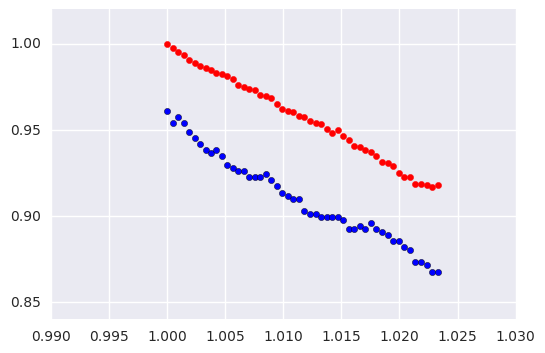

In [175]:
# values = []
cv = CountVectorizer()
tfidf = TfidfTransformer()

X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)
X_train_dtm = tfidf.fit_transform(X_train_dtm)
X_test_dtm = tfidf.transform(X_test_dtm)

for alpha in list(np.logspace(.00001, .01)):
    
    clf = SGDClassifier(random_state=0, alpha=np.log(alpha), penalty='l2')
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)
    plt.scatter(alpha, accuracy_score(y_test, y_pred))
    plt.scatter(alpha, accuracy_score(y_train, clf.predict(X_train_dtm)), color='red')

In [220]:
def get_important_df(sgd_clf, vect):
    
    sgd_clf.densify()
    ndf = pd.DataFrame(clf.coef_.T, columns=train.target_names)
    ndf['Token'] = cv.get_feature_names()
    return ndf

In [247]:
def get_most_important(ratio_df, num, return_tokens=False, ascending=False):
    
    list_tokens = []
    for column in ratio_df.columns[:-1]:
        ratio_df = ratio_df.sort_values(by=column, ascending=ascending)
        list_tokens += ratio_df.iloc[:num]['Token'].tolist()
        if return_tokens == False:
            print("Token coefficients for {}:\n".format(column), ratio_df[['Token', column]][:num])
    if return_tokens == True:
        return list(set(list_tokens))
     

In [225]:
mdf = get_important_df(clf, cv)

In [251]:
get_most_important(mdf, 10)

In [241]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

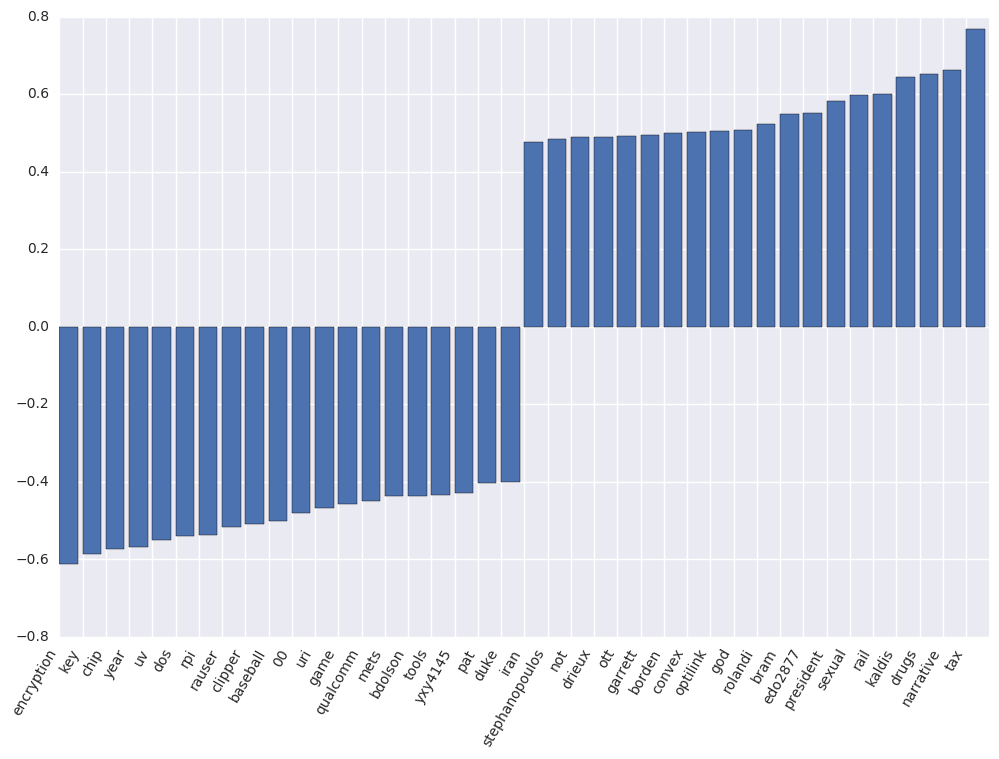

In [243]:
names = pd.Series(cv.get_feature_names())
plt.figure(figsize=(12,8))
plot_important_features(mdf['talk.politics.misc'], names)

In [253]:
top_words = get_most_important(mdf, 100, return_tokens=True, ascending=True)

In [254]:
top_words += get_most_important(mdf, 100, return_tokens=True, ascending=False)

In [255]:
len(top_words)

945

In [256]:
len(set(top_words))

775

In [257]:
cv = CountVectorizer(vocabulary=set(top_words))
clf = SGDClassifier(random_state=0)
tfidf = TfidfTransformer()

X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

X_train_dtm = tfidf.fit_transform(X_train_dtm)
X_test_dtm = tfidf.transform(X_test_dtm)

clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.95      0.85      0.90       114
          1       0.99      0.91      0.95       132
          2       0.96      0.97      0.96       117
          3       0.82      0.95      0.88       116
          4       0.91      0.95      0.93        88

avg / total       0.93      0.92      0.92       567

Confusion Matrix: 
[[ 97   0   1  15   1]
 [  1 120   1   7   3]
 [  0   1 113   1   2]
 [  4   0   0 110   2]
 [  0   0   3   1  84]]

Accuracy: 0.9241622574955908


In [259]:
cv = CountVectorizer(stop_words='english', max_df=.4, max_features=800)
clf = SGDClassifier(random_state=0)
tfidf = TfidfTransformer()

X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

X_train_dtm = tfidf.fit_transform(X_train_dtm)
X_test_dtm = tfidf.transform(X_test_dtm)

clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.93      0.88      0.90       114
          1       0.93      0.95      0.94       132
          2       0.92      0.93      0.93       117
          3       0.85      0.84      0.85       116
          4       0.89      0.94      0.92        88

avg / total       0.91      0.91      0.91       567

Confusion Matrix: 
[[100   0   1  12   1]
 [  1 125   1   1   4]
 [  2   0 109   3   3]
 [  4   9   3  98   2]
 [  0   0   4   1  83]]

Accuracy: 0.908289241622575


In [441]:
results = []
start = 50#50
end = 400#200
intervals = np.linspace(start, end, num=10)
for num in [int(x) for x in intervals]:
    
    best_tokens = get_most_important(mdf, num, return_tokens=True, ascending=False)
    best_tokens += get_most_important(mdf, num, return_tokens=True, ascending=True)
    
    best_cv = CountVectorizer(vocabulary=set(best_tokens), ngram_range=(1,1))
    best_tfidf = TfidfTransformer()
    
    best_train_dtm = best_cv.fit_transform(X_train)
    
    best_nb = MultinomialNB()
    best_nb.fit(best_train_dtm, y_train)
    best_nb_acc = accuracy_score(y_test, best_nb.predict(best_cv.transform(X_test)))
    
    best_sgd = SGDClassifier(random_state=0)
    best_train_dtm = best_tfidf.fit_transform(best_train_dtm)
    best_test_dtm = best_tfidf.transform(best_cv.transform(X_test))
    best_sgd.fit(best_train_dtm, y_train)
    
    best_sgd_acc = accuracy_score(y_test, best_sgd.predict(best_test_dtm))
                                 
    
    max_cv = CountVectorizer(max_features=len(set(best_tokens)), ngram_range=(1,1), stop_words='english', max_df=.2)
    max_tfidf = TfidfTransformer()
    max_train_dtm = max_cv.fit_transform(X_train)
    
    max_nb = MultinomialNB()
    max_nb.fit(max_train_dtm, y_train)
    max_nb_acc = accuracy_score(y_test, max_nb.predict(max_cv.transform(X_test)))
                                  
    max_sgd = SGDClassifier(random_state=0)
    max_train_dtm = max_tfidf.fit_transform(max_train_dtm)
    max_test_dtm = max_tfidf.transform(max_cv.transform(X_test))
    max_sgd.fit(max_train_dtm, y_train)
    max_sgd_acc = accuracy_score(y_test, max_sgd.predict(max_cv.transform(X_test)))
    
    results.append((len(set(best_tokens)), best_nb_acc, best_sgd_acc, max_nb_acc, max_sgd_acc))                            

In [442]:
results_df = pd.DataFrame(results, columns=['Num_Features', 'Best_NB', 'Best_SGD', 'Max_NB', 'Max_SGD'])

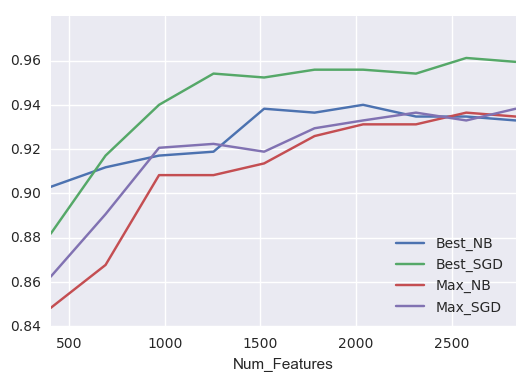

In [443]:
plt.figure(figsize=(8,8))
results_df.set_index('Num_Features').plot()

<a id='3'></a>
# 3 Tuning Models

The models default parameters give us a good model, but if we want a great model we'll have to start turning the knobs and find our own optimal parameters

<a id='3.1'></a>
## 3.1 Pipeline

Typing new parameters and keeping track of their results is a pain, lucky for us sklearn has a wonderful class called pipeline so we don't have to do that.

<a id='3.1.1'></a>
### 3.1.1 Description

__FROM SKLEARN [DOCUMENTATION](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):__

Pipeline of transforms with a final estimator.

Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit.

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a ‘\_\_’, as in the example below. A step’s estimator may be replaced entirely by setting the parameter with its name to another estimator, or a transformer removed by setting to None.

<a id='3.1.2'></a>
### 3.1.2 Example

__1.__ We'll create a simple pipeline for SGDClassifier using the [make_pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) function in sklearn

In [287]:
pipe = make_pipeline(CountVectorizer(), TfidfTransformer(), SGDClassifier(random_state=0))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.95      0.91      0.93       114
          1       0.98      0.98      0.98       132
          2       0.97      0.97      0.97       117
          3       0.91      0.97      0.94       116
          4       0.98      0.94      0.96        88

avg / total       0.96      0.96      0.96       567

Confusion Matrix: 
[[104   1   0   8   1]
 [  1 129   1   1   0]
 [  0   0 114   2   1]
 [  2   0   1 113   0]
 [  2   1   2   0  83]]

Accuracy: 0.9576719576719577


__2.__ We'll now build a pipeline without the make_pipeline helper function

In [288]:
pipeline = Pipeline([
        ('cv', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('sgd', SGDClassifier(random_state=0))
    ])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
evaluate_model(y_test, y_pred)

Classification report: 
             precision    recall  f1-score   support

          0       0.95      0.91      0.93       114
          1       0.98      0.98      0.98       132
          2       0.97      0.97      0.97       117
          3       0.91      0.97      0.94       116
          4       0.98      0.94      0.96        88

avg / total       0.96      0.96      0.96       567

Confusion Matrix: 
[[104   1   0   8   1]
 [  1 129   1   1   0]
 [  0   0 114   2   1]
 [  2   0   1 113   0]
 [  2   1   2   0  83]]

Accuracy: 0.9576719576719577


<a id='3.2'></a>
## 3.2 Parameter Search

The main reason these pipelines are used is to help people with parameter searching. There are two popular parameter search classes in sklearn

<a id='3.2.1'></a>
### 3.2.1 GridSearchCV

This is most well known searching technique in sklearn

<a id='3.2.1.1'></a>
#### 3.2.1.1 Description

__FROM SKLEARN [DOCUMENTATION](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):__

Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

<a id='3.2.1.2'></a>
#### 3.2.1.2 Example

We'll show a small grid search for the optimal parameters for our multinomial naive bayes model

In [308]:
pipe = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

#These are the parameters we're searching over
params = {
    'countvectorizer__ngram_range':[(1,1), (1,2)],
    #'countvectorizer__min_df':[2, 3, 4, 5],
    #'countvectorizer__max_df':[.2, .4, .6, .8, 1.0],
    'tfidftransformer__norm':['l2', None],
    'tfidftransformer__use_idf':[True, False],
    #'multinomialnb__alpha':[.001, .01, .1, 1]
}
grid = GridSearchCV(pipe, params, cv=5, verbose=True, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   37.8s finished


Best CV Score: 0.96
Best parameters: {'countvectorizer__ngram_range': (1, 2), 'tfidftransformer__use_idf': True, 'tfidftransformer__norm': None}
Classification report for test sample held out: 
             precision    recall  f1-score   support

          0       0.96      0.87      0.91       114
          1       0.98      0.97      0.97       132
          2       0.96      0.99      0.97       117
          3       0.90      0.97      0.93       116
          4       0.97      0.95      0.96        88

avg / total       0.95      0.95      0.95       567



In [433]:
from sklearn.metrics import precision_score, recall_score, auc
def evaluate_grid(_grid, metric='accurracy'):
    print("Best CV Score: {:.2f}".format(_grid.best_score_))
    print("Best parameters: {}".format(_grid.best_params_))
    y_pred = _grid.predict(X_test)
    print("\tf1 score on test: {}".format(f1_score(y_test, y_pred, average='macro')))
    print("\tprecision score on test: {}".format(precision_score(y_test, y_pred, average='macro')))
    print("\trecall score on test: {}".format(recall_score(y_test, y_pred, average='macro')))
    print("\taccuracy score on test: {}".format(accuracy_score(y_test, y_pred)))
    #print("\taccuracy score on test: {}".format(accuracy_score(_y_test, y_pred)))
    print("Classification report for test sample held out: \n{}".format(classification_report(y_test, y_pred)))
    print("Confusion Matrix for test: \n{}".format(confusion_matrix(y_test, y_pred)))
    

Scores for each cross-validation are saved inside GridSearchCV object

In [313]:
results = pd.DataFrame(grid.cv_results_).fillna('None')

In [314]:
res_pivot = results.pivot_table(values=['mean_test_score', 'mean_train_score'],
                                index=["param_countvectorizer__ngram_range", "param_tfidftransformer__use_idf",
                                       "param_tfidftransformer__norm"])

In [315]:
res_pivot.mean_test_score

param_countvectorizer__ngram_range  param_tfidftransformer__use_idf  param_tfidftransformer__norm
(1, 1)                              False                            None                            0.945278
                                                                     l2                              0.779788
                                    True                             None                            0.957635
                                                                     l2                              0.893645
(1, 2)                              False                            None                            0.922330
                                                                     l2                              0.779347
                                    True                             None                            0.960724
                                                                     l2                              0.891439
Name: mean_test_score,

<a id='3.2.1.3'></a>
#### 3.2.1.3 Parameters

GridSearchCV has some very important parameters that will save you time

__scoring :__ string, callable or None, default=None

A string (see model evaluation documentation) or a scorer callable object / function with signature scorer(estimator, X, y). If None, the score method of the estimator is used.

__[LIST OF SCORING FUNCTIONS](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter):__

<img src="./sklearn_scoring_table.png">

In [434]:
scoring = ['accuracy', 'precision', 'f1']
@interact
def try_score(score=scoring):
    pipe = make_pipeline(CountVectorizer(max_features=1000), TfidfTransformer(), MultinomialNB())

    #These are the parameters we're searching over
    params = {
        #'countvectorizer__ngram_range':[(1,1), (1,2)],
        #'countvectorizer__min_df':[2, 3, 4, 5],
        #'countvectorizer__max_df':[.2, .4, .6, .8, 1.0],
        'tfidftransformer__norm':['l1', 'l2', None],
        'tfidftransformer__use_idf':[True, False],
        'multinomialnb__alpha':[.001, .01, .1, 1]
    }
    grid = GridSearchCV(pipe, params, cv=3, verbose=True, n_jobs=-1, scoring=score)
    grid.fit(X_train, y_train)
    evaluate_grid(grid)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Program Files\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
C:\Program Files\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000000001118810, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-35.pyc', '__doc__': None, '__file__': r'C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Program ...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000000001118810, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-35.pyc', '__doc__': None, '__file__': r'C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Program ...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method CommManager.comm_msg of <ipykernel.comm.manager.CommManager object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'2C914941E9DA41B38D39B154D5B1EBFA']
        msg = {'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\comm\manager.py in comm_msg(self=<ipykernel.comm.manager.CommManager object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'2C914941E9DA41B38D39B154D5B1EBFA'], msg={'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}})
    106         comm = self.get_comm(comm_id)
    107         if comm is None:
    108             return
    109 
    110         try:
--> 111             comm.handle_msg(msg)
        comm.handle_msg = <bound method Comm.handle_msg of <ipykernel.comm.comm.Comm object>>
        msg = {'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}}
    112         except Exception:
    113             self.log.error('Exception in comm_msg for %s', comm_id, exc_info=True)
    114 
    115     def comm_close(self, stream, ident, msg):

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\comm\comm.py in handle_msg(self=<ipykernel.comm.comm.Comm object>, msg={'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}})
    149         self.log.debug("handle_msg[%s](%s)", self.comm_id, msg)
    150         if self._msg_callback:
    151             shell = self.kernel.shell
    152             if shell:
    153                 shell.events.trigger('pre_execute')
--> 154             self._msg_callback(msg)
        self._msg_callback = <bound method _show_traceback.<locals>.m of <ipywidgets.widgets.widget_selection.Dropdown object>>
        msg = {'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}}
    155             if shell:
    156                 shell.events.trigger('post_execute')
    157 
    158 

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py in m(self=<ipywidgets.widgets.widget_selection.Dropdown object>, *args=({'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}},), **kwargs={})
     88 
     89 def _show_traceback(method):
     90     """decorator for showing tracebacks in IPython"""
     91     def m(self, *args, **kwargs):
     92         try:
---> 93             return(method(self, *args, **kwargs))
        self = <ipywidgets.widgets.widget_selection.Dropdown object>
        args = ({'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}},)
        kwargs = {}
     94         except Exception as e:
     95             ip = get_ipython()
     96             if ip is None:
     97                 self.log.warn("Exception in widget method %s: %s", method, e, exc_info=True)

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py in _handle_msg(self=<ipywidgets.widgets.widget_selection.Dropdown object>, msg={'buffers': [], 'content': {'comm_id': '278107399f4b41388c72333aead7321b', 'data': {'buffer_keys': [], 'method': 'backbone', 'sync_data': {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}}}, 'header': {'date': '2017-04-15T17:57:26.241683', 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'session': '2C914941E9DA41B38D39B154D5B1EBFA', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4218E6CB8BB14AA598F2439A1CDD3B93', 'msg_type': 'comm_msg', 'parent_header': {}})
    423             if 'sync_data' in data:
    424                 # get binary buffers too
    425                 sync_data = data['sync_data']
    426                 for i,k in enumerate(data.get('buffer_keys', [])):
    427                     sync_data[k] = msg['buffers'][i]
--> 428                 self.set_state(sync_data) # handles all methods
        self.set_state = <bound method Widget.set_state of <ipywidgets.widgets.widget_selection.Dropdown object>>
        sync_data = {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}
    429 
    430         # Handle a state request.
    431         elif method == 'request_state':
    432             self.send_state()

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py in set_state(self=<ipywidgets.widgets.widget_selection.Dropdown object>, sync_data={'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...})
    302         with self._lock_property(**sync_data), self.hold_trait_notifications():
    303             for name in sync_data:
    304                 if name in self.keys:
    305                     from_json = self.trait_metadata(name, 'from_json',
    306                                                     self._trait_from_json)
--> 307                     self.set_trait(name, from_json(sync_data[name], self))
        self.set_trait = <bound method HasTraits.set_trait of <ipywidgets.widgets.widget_selection.Dropdown object>>
        name = '_options_labels'
        from_json = <function Widget._trait_from_json>
        sync_data = {'_dom_classes': [], '_model_module': 'jupyter-js-widgets', '_model_name': 'DropdownModel', '_options_labels': ['accuracy', 'precision', 'f1'], '_view_module': 'jupyter-js-widgets', '_view_name': 'DropdownView', 'background_color': None, 'button_style': '', 'color': None, 'description': 'score', ...}
        self = <ipywidgets.widgets.widget_selection.Dropdown object>
    308 
    309     def send(self, content, buffers=None):
    310         """Sends a custom msg to the widget model in the front-end.
    311 

...........................................................................
C:\Program Files\Anaconda3\lib\contextlib.py in __exit__(self=<contextlib._GeneratorContextManager object>, type=None, value=None, traceback=None)
     61             raise RuntimeError("generator didn't yield") from None
     62 
     63     def __exit__(self, type, value, traceback):
     64         if type is None:
     65             try:
---> 66                 next(self.gen)
        self.gen = <generator object hold_trait_notifications>
     67             except StopIteration:
     68                 return
     69             else:
     70                 raise RuntimeError("generator didn't stop")

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\traitlets\traitlets.py in hold_trait_notifications(self=<ipywidgets.widgets.widget_selection.Dropdown object>)
   1124                 del self.notify_change
   1125 
   1126                 # trigger delayed notifications
   1127                 for changes in cache.values():
   1128                     for change in changes:
-> 1129                         self.notify_change(change)
        self.notify_change = <bound method Widget.notify_change of <ipywidgets.widgets.widget_selection.Dropdown object>>
        change = {'new': 'f1', 'type': 'change', 'old': 'accuracy...n object at 0x0000000015FCB978>, 'name': 'value'}
   1130 
   1131     def _notify_trait(self, name, old_value, new_value):
   1132         self.notify_change(Bunch(
   1133             name=name,

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py in notify_change(self=<ipywidgets.widgets.widget_selection.Dropdown object>, change={'new': 'f1', 'type': 'change', 'old': 'accuracy...n object at 0x0000000015FCB978>, 'name': 'value'})
    363         if self.comm is not None and name in self.keys:
    364             # Make sure this isn't information that the front-end just sent us.
    365             if self._should_send_property(name, change['new']):
    366                 # Send new state to front-end
    367                 self.send_state(key=name)
--> 368         LoggingConfigurable.notify_change(self, change)
        self = <ipywidgets.widgets.widget_selection.Dropdown object>
        change = {'new': 'f1', 'type': 'change', 'old': 'accuracy...n object at 0x0000000015FCB978>, 'name': 'value'}
    369 
    370     #-------------------------------------------------------------------------
    371     # Support methods
    372     #-------------------------------------------------------------------------

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\traitlets\traitlets.py in notify_change(self=<ipywidgets.widgets.widget_selection.Dropdown object>, change={'new': 'f1', 'type': 'change', 'old': 'accuracy...n object at 0x0000000015FCB978>, 'name': 'value'})
   1169             if isinstance(c, _CallbackWrapper):
   1170                 c = c.__call__
   1171             elif isinstance(c, EventHandler) and c.name is not None:
   1172                 c = getattr(self, c.name)
   1173 
-> 1174             c(change)
        c = <function interactive.<locals>.call_f>
        change = {'new': 'f1', 'type': 'change', 'old': 'accuracy...n object at 0x0000000015FCB978>, 'name': 'value'}
   1175 
   1176     def _add_notifiers(self, handler, name, type):
   1177         if name not in self._trait_notifiers:
   1178             nlist = []

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\ipywidgets\widgets\interaction.py in call_f(*args=({'new': 'f1', 'type': 'change', 'old': 'accuracy...n object at 0x0000000015FCB978>, 'name': 'value'},))
    255         if co:
    256             clear_output(wait=True)
    257         if manual:
    258             manual_button.disabled = True
    259         try:
--> 260             container.result = f(**container.kwargs)
    261             if container.result is not None:
    262                 display(container.result)
    263         except Exception as e:
    264             ip = get_ipython()

...........................................................................
C:\Users\Colin\Documents\GitHub\Text_Mining_Python_Lecture\<ipython-input-434-9753d3a5622e> in try_score(score='f1')
     11         'tfidftransformer__norm':['l1', 'l2', None],
     12         'tfidftransformer__use_idf':[True, False],
     13         'multinomialnb__alpha':[.001, .01, .1, 1]
     14     }
     15     grid = GridSearchCV(pipe, params, cv=3, verbose=True, n_jobs=-1, scoring=score)
---> 16     grid.fit(X_train, y_train)
     17     evaluate_grid(grid)
     18 
     19 
     20 

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e...in_score=True,
       scoring='f1', verbose=True), X=2001    From: mss@netcom.com (Mark Singer)\nSubj...ohio-state.edu\nSubj...
Name: Text, dtype: object, y=2001    1
57      4
1935    1
2524    0
238     ... 3
2607    1
2732    4
Name: Target, dtype: int64, groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...n_score=True,
       scoring='f1', verbose=True)>
        X = 2001    From: mss@netcom.com (Mark Singer)\nSubj...ohio-state.edu\nSubj...
Name: Text, dtype: object
        y = 2001    1
57      4
1935    1
2524    0
238     ... 3
2607    1
2732    4
Name: Target, dtype: int64
        groups = None
        self.param_grid = {'multinomialnb__alpha': [0.001, 0.01, 0.1, 1], 'tfidftransformer__norm': ['l1', 'l2', None], 'tfidftransformer__use_idf': [True, False]}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in _fit(self=GridSearchCV(cv=3, error_score='raise',
       e...in_score=True,
       scoring='f1', verbose=True), X=2001    From: mss@netcom.com (Mark Singer)\nSubj...ohio-state.edu\nSubj...
Name: Text, dtype: object, y=2001    1
57      4
1935    1
2524    0
238     ... 3
2607    1
2732    4
Name: Target, dtype: int64, groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Apr 15 17:57:31 2017
PID: 9588               Python 3.5.2: C:\Program Files\Anaconda3\python.exe
...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(steps=[('countvectorizer', CountVectori...alpha=0.001, class_prior=None, fit_prior=True))]), 2001    From: mss@netcom.com (Mark Singer)\nSubj...ohio-state.edu\nSubj...
Name: Text, dtype: object, 2001    1
57      4
1935    1
2524    0
238     ... 3
2607    1
2732    4
Name: Target, dtype: int64, make_scorer(f1_score), array([ 710,  725,  726, ..., 2263, 2264, 2265]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 773, 774, 777, 780, 781,
       784, 786, 794]), True, {'multinomialnb__alpha': 0.001, 'tfidftransformer__norm': 'l1', 'tfidftransformer__use_idf': True}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(steps=[('countvectorizer', CountVectori...alpha=0.001, class_prior=None, fit_prior=True))]), 2001    From: mss@netcom.com (Mark Singer)\nSubj...ohio-state.edu\nSubj...
Name: Text, dtype: object, 2001    1
57      4
1935    1
2524    0
238     ... 3
2607    1
2732    4
Name: Target, dtype: int64, make_scorer(f1_score), array([ 710,  725,  726, ..., 2263, 2264, 2265]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 773, 774, 777, 780, 781,
       784, 786, 794]), True, {'multinomialnb__alpha': 0.001, 'tfidftransformer__norm': 'l1', 'tfidftransformer__use_idf': True})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=Pipeline(steps=[('countvectorizer', CountVectori...alpha=0.001, class_prior=None, fit_prior=True))]), X=2001    From: mss@netcom.com (Mark Singer)\nSubj...ohio-state.edu\nSubj...
Name: Text, dtype: object, y=2001    1
57      4
1935    1
2524    0
238     ... 3
2607    1
2732    4
Name: Target, dtype: int64, scorer=make_scorer(f1_score), train=array([ 710,  725,  726, ..., 2263, 2264, 2265]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 773, 774, 777, 780, 781,
       784, 786, 794]), verbose=True, parameters={'multinomialnb__alpha': 0.001, 'tfidftransformer__norm': 'l1', 'tfidftransformer__use_idf': True}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = Pipeline(steps=[('countvectorizer', CountVectori...alpha=0.001, class_prior=None, fit_prior=True))])
        X_test = 2001    From: mss@netcom.com (Mark Singer)\nSubj...m (Ron "Asbestos" Di...
Name: Text, dtype: object
        y_test = 2001    1
57      4
1935    1
2524    0
238     ... 2
1076    2
717     2
Name: Target, dtype: int64
        scorer = make_scorer(f1_score)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=Pipeline(steps=[('countvectorizer', CountVectori...alpha=0.001, class_prior=None, fit_prior=True))]), X_test=2001    From: mss@netcom.com (Mark Singer)\nSubj...m (Ron "Asbestos" Di...
Name: Text, dtype: object, y_test=2001    1
57      4
1935    1
2524    0
238     ... 2
1076    2
717     2
Name: Target, dtype: int64, scorer=make_scorer(f1_score))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(f1_score)
        estimator = Pipeline(steps=[('countvectorizer', CountVectori...alpha=0.001, class_prior=None, fit_prior=True))])
        X_test = 2001    From: mss@netcom.com (Mark Singer)\nSubj...m (Ron "Asbestos" Di...
Name: Text, dtype: object
        y_test = 2001    1
57      4
1935    1
2524    0
238     ... 2
1076    2
717     2
Name: Target, dtype: int64
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(f1_score), estimator=Pipeline(steps=[('countvectorizer', CountVectori...alpha=0.001, class_prior=None, fit_prior=True))]), X=2001    From: mss@netcom.com (Mark Singer)\nSubj...m (Ron "Asbestos" Di...
Name: Text, dtype: object, y_true=2001    1
57      4
1935    1
2524    0
238     ... 2
1076    2
717     2
Name: Target, dtype: int64, sample_weight=None)
     93             return self._sign * self._score_func(y_true, y_pred,
     94                                                  sample_weight=sample_weight,
     95                                                  **self._kwargs)
     96         else:
     97             return self._sign * self._score_func(y_true, y_pred,
---> 98                                                  **self._kwargs)
        self._kwargs = {}
     99 
    100 
    101 class _ProbaScorer(_BaseScorer):
    102     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py in f1_score(y_true=2001    1
57      4
1935    1
2524    0
238     ... 2
1076    2
717     2
Name: Target, dtype: int64, y_pred=array([1, 2, 1, 0, 1, 3, 3, 1, 1, 0, 2, 0, 3, 0,...0, 4, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2], dtype=int64), labels=None, pos_label=1, average='binary', sample_weight=None)
    687 
    688 
    689     """
    690     return fbeta_score(y_true, y_pred, 1, labels=labels,
    691                        pos_label=pos_label, average=average,
--> 692                        sample_weight=sample_weight)
        sample_weight = None
    693 
    694 
    695 def fbeta_score(y_true, y_pred, beta, labels=None, pos_label=1,
    696                 average='binary', sample_weight=None):

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py in fbeta_score(y_true=2001    1
57      4
1935    1
2524    0
238     ... 2
1076    2
717     2
Name: Target, dtype: int64, y_pred=array([1, 2, 1, 0, 1, 3, 3, 1, 1, 0, 2, 0, 3, 0,...0, 4, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2], dtype=int64), beta=1, labels=None, pos_label=1, average='binary', sample_weight=None)
    801                                                  beta=beta,
    802                                                  labels=labels,
    803                                                  pos_label=pos_label,
    804                                                  average=average,
    805                                                  warn_for=('f-score',),
--> 806                                                  sample_weight=sample_weight)
        sample_weight = None
    807     return f
    808 
    809 
    810 def _prf_divide(numerator, denominator, metric, modifier, average, warn_for):

...........................................................................
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py in precision_recall_fscore_support(y_true=array([1, 4, 1, 0, 3, 4, 3, 1, 1, 0, 4, 0, 3, 0,...0, 4, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2], dtype=int64), y_pred=array([1, 2, 1, 0, 1, 3, 3, 1, 1, 0, 2, 0, 3, 0,...0, 4, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2], dtype=int64), beta=1, labels=None, pos_label=1, average='binary', warn_for=('f-score',), sample_weight=None)
   1013                     raise ValueError("pos_label=%r is not a valid label: %r" %
   1014                                      (pos_label, present_labels))
   1015             labels = [pos_label]
   1016         else:
   1017             raise ValueError("Target is %s but average='binary'. Please "
-> 1018                              "choose another average setting." % y_type)
        y_type = 'multiclass'
   1019     elif pos_label not in (None, 1):
   1020         warnings.warn("Note that pos_label (set to %r) is ignored when "
   1021                       "average != 'binary' (got %r). You may use "
   1022                       "labels=[pos_label] to specify a single positive class."

ValueError: Target is multiclass but average='binary'. Please choose another average setting.
___________________________________________________________________________

__n_jobs :__ int, default=1

Number of jobs to run in parallel.

In [320]:
t0 = time()
n_jobs = 1
pipe = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

#These are the parameters we're searching over
params = {
    'countvectorizer__ngram_range':[(1,1), (1,2)],
    'countvectorizer__stop_words':['english', None],
    #'countvectorizer__min_df':[2, 3, 4, 5],
    #'countvectorizer__max_df':[.2, .4, .6, .8, 1.0],
    'tfidftransformer__norm':[None],
    'tfidftransformer__use_idf':[False]
}
grid = GridSearchCV(pipe, params, cv=5, verbose=True, n_jobs=n_jobs)
grid.fit(X_train, y_train)
print('Took {} seconds with n_jobs={}'.format(time()-t0, n_jobs))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.6min finished


Took 158.91267943382263 seconds with n_jobs=1


In [321]:
t0 = time()
n_jobs = -1
pipe = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

#These are the parameters we're searching over
params = {
    'countvectorizer__ngram_range':[(1,1), (1,2)],
    'countvectorizer__stop_words':['english', None],
    #'countvectorizer__min_df':[2, 3, 4, 5],
    #'countvectorizer__max_df':[.2, .4, .6, .8, 1.0],
    'tfidftransformer__norm':[None],
    'tfidftransformer__use_idf':[False],
}
grid = GridSearchCV(pipe, params, cv=5, verbose=True, n_jobs=n_jobs)
grid.fit(X_train, y_train)
print('Took {} seconds with n_jobs={}'.format(time()-t0, n_jobs))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.5s finished


Took 21.6882541179657 seconds with n_jobs=-1


__cv :__ int, cross-validation generator or an iterable, optional

Determines the cross-validation splitting strategy. Possible inputs for cv are:

  * None, to use the default 3-fold cross validation,

  * integer, to specify the number of folds in a (Stratified)KFold,

  * An object to be used as a cross-validation generator.

  * An iterable yielding train, test splits.

For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) is used. In all other cases, KFold is used.

Refer [User Guide](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) for the various cross-validation strategies that can be used here.

In [337]:
from sklearn.model_selection import ShuffleSplit

shufflesplit = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
pipe = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

#These are the parameters we're searching over
params = {
    'countvectorizer__ngram_range':[(1,1), (1,2)],
    #'countvectorizer__min_df':[2, 3, 4, 5],
    #'countvectorizer__max_df':[.2, .4, .6, .8, 1.0],
    #'tfidftransformer__norm':['l2', None],
    #'tfidftransformer__use_idf':[True, False],
    #'multinomialnb__alpha':[.001, .01, .1, 1]
}
grid = GridSearchCV(pipe, params, cv=shufflesplit, verbose=True, n_jobs=-1)
grid.fit(X_train, y_train)
evaluate_grid(grid)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   11.2s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s finished


Best CV Score: 0.88
Best parameters: {'countvectorizer__ngram_range': (1, 2)}
Classification report for test sample held out: 
             precision    recall  f1-score   support

          0       0.99      0.78      0.87       114
          1       0.96      0.96      0.96       132
          2       0.71      1.00      0.83       117
          3       0.92      0.87      0.89       116
          4       1.00      0.80      0.89        88

avg / total       0.91      0.89      0.89       567



<a id='3.2.2'></a>
### 3.2.2 RandomizedSearchCV

__FROM SKLEARN [DOCUMENTATION](http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search):__

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

  * A budget can be chosen independent of the number of parameters and possible values.
  * Adding parameters that do not influence the performance does not decrease efficiency.
  
Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for GridSearchCV.

Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the n_iter parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified:

<a id='3.2.2.1'></a>
#### 3.2.2.1 Description

__FROM SKLEARN [DOCUMENTATION](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):__

Randomized search on hyper parameters.

RandomizedSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.
In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. It is highly recommended to use continuous distributions for continuous parameters.

<a id='3.2.2.2'></a>
#### 3.2.2.2 Example

RandomizedSearchCV is very similar to GridSearchCV with the only difference being n_iter parameter which will allow us to select from a bigger parameter grid

In [373]:
pipe = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

#These are the parameters we're searching over
params = {
    'countvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
    'countvectorizer__min_df':[0,2,3,4,5,6,7,8,9,10],
    'countvectorizer__max_df':[.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0],
    'tfidftransformer__norm':['l1', 'l2', None],
    'tfidftransformer__use_idf':[True, False],
    'multinomialnb__alpha':[.00001, .0001, .001, .01, .1, 1]
}
grid = RandomizedSearchCV(pipe, params, cv=5, verbose=True, n_iter=40, n_jobs=-1)
grid.fit(X_train, y_train)
evaluate_grid(grid)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.3min finished


Best CV Score: 0.96
Best parameters: {'multinomialnb__alpha': 0.01, 'countvectorizer__ngram_range': (1, 2), 'countvectorizer__min_df': 2, 'tfidftransformer__norm': 'l2', 'tfidftransformer__use_idf': True, 'countvectorizer__max_df': 0.9}
Classification report for test sample held out: 
             precision    recall  f1-score   support

          0       0.96      0.89      0.93       114
          1       0.98      0.97      0.98       132
          2       0.97      0.98      0.97       117
          3       0.90      0.96      0.93       116
          4       0.95      0.95      0.95        88

avg / total       0.95      0.95      0.95       567



<a id='4'></a>
# 4 Increasing Performance

There are many ways to increase model performance. The best way is typically feature engineering, but we're just covering text mining here

<a id='4.1'></a>
## 4.1 Stemming

One thing we can do is stem our text to shrink our feature space. This sometimes gives a better model but not always, sometimes the different classes with use different suffixes

In [386]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
import nltk

<a id='4.1.1'></a>
### 4.1.1 Types

We will only focus on three of the more popular stemmers

### Porter

This is the most common stemmer

__EXAMPLE__

In [375]:
p_stemmer = PorterStemmer()

In [379]:
p_stemmer.stem('player')

'player'

### Lancaster

This is a more aggresive stemmer, meaning it will chop off suffixes more frequently

__EXAMPLE__

In [377]:
l_stemmer = LancasterStemmer()

In [380]:
l_stemmer.stem('player')

'play'

### Snowball 

Adapted version of Porter, must specify the language

__EXAMPLE__

In [381]:
s_stemmer = SnowballStemmer('english')

In [382]:
s_stemmer.stem('generously')

'generous'

In [383]:
p_stemmer.stem('generously')

'gener'

In [384]:
l_stemmer.stem('generously')

'gen'

<a id='4.1.2'></a>
### 4.1.2 Stemming our Text

Before we begin stemming our words we need to make sure stop_words aren't being stemmed because they won't be picked up by our CountVectorizer if the word is different.

In [387]:
stop_words = nltk.corpus.stopwords.words('english')

In [388]:
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [391]:
for word in stop_words[50:100]:
    
    if len(word) > 5:
        print('\nStop word: {}'.format(word))
        print('\tPorter: {}\n\tLancaster: {}\n\tSnowball: {}'.format(p_stemmer.stem(word), l_stemmer.stem(word),
                                                                          s_stemmer.stem(word)))


Stop word: because
	Porter: becaus
	Lancaster: becaus
	Snowball: becaus

Stop word: against
	Porter: against
	Lancaster: against
	Snowball: against

Stop word: between
	Porter: between
	Lancaster: between
	Snowball: between

Stop word: through
	Porter: through
	Lancaster: through
	Snowball: through

Stop word: during
	Porter: dure
	Lancaster: dur
	Snowball: dure

Stop word: before
	Porter: befor
	Lancaster: bef
	Snowball: befor

Stop word: further
	Porter: further
	Lancaster: furth
	Snowball: further


We will then have to ignore these words when stemming

In [392]:
token_regex = re.compile('(?u)\\b\\w\\w+\\b')
def stem_column(col, stemmer, stop_words):
    return col.apply(lambda x: ' '.join([stemmer.stem(token) if token not in stop_words else token
                                         for token in token_regex.findall(x)]))

In [393]:
test_df = df['Text'].head(10)
snowball_text = stem_column(test_df, s_stemmer, stop_words)
porter_text = stem_column(test_df, p_stemmer, stop_words)
lancaster_text = stem_column(test_df, l_stemmer, stop_words)

In [394]:
i = 3
print('Original: \n{}'.format(test_df.iloc[i]))
print('\nSnowball Stemmed: \n\n{}'.format(snowball_text.iloc[i]))
print('\nPorter Stemmed: \n\n{}'.format(snowball_text.iloc[i]))
print('\nLancaster Stemmed: \n\n{}'.format(snowball_text.iloc[i]))

Original: 
From: rosen@kranz.enet.dec.com (Jim Rosenkranz)
Subject: Re: Metal powder,steel,iron.
Reply-To: rosen@kranz.enet.dec.com (Jim Rosenkranz)
Organization: Digital Equipment Corp.
Lines: 26

In article <79557@cup.portal.com>, mmm@cup.portal.com (Mark Robert Thorson) writes:
|>Xref: nntpd2.cxo.dec.com misc.invest:40997 misc.forsale:88577
|>Path: nntpd2.cxo.dec.com!pa.dec.com!e2big.mko.dec.com!uvo.dec.com!news.crl.dec.com!deccrl!caen!zaphod.mps.ohio-state.edu!sdd.hp.com!portal!cup.portal.com!mmm
|>From: mmm@cup.portal.com (Mark Robert Thorson)
|>Newsgroups: misc.invest,misc.forsale
|>Subject: Re: Metal powder,steel,iron.
|>Message-ID: <79557@cup.portal.com>
|>Date: Thu, 15 Apr 93 08:53:51 PDT
|>Organization: The Portal System (TM)
|>References:  <ACpDgohaWA@commed.msk.su>
|>Lines: 4
|>
|>I just love these posts from the ex-Soviet Union.  Among the cars, dinette
|>sets, video cameras, etc. every now and then an ad pops up for bee venom,
|>RED OXIDE OF MERCURY, cobalt (100 tons mini

In [396]:
df['snowball_text'] = stem_column(df['Text'], s_stemmer, stop_words)
df['porter_text'] = porter_text = stem_column(df['Text'], p_stemmer, stop_words)
df['lancaster_text'] = lancaster_text = stem_column(df['Text'], l_stemmer, stop_words)

In [397]:
for col in ['Text', 'snowball_text', 'porter_text', 'lancaster_text']:
    cv = CountVectorizer(stop_words='english')
    dtm = cv.fit_transform(df[col])
    print('There are {} tokens for column: {}'.format(dtm.shape[1], col))

There are 38546 tokens for column: Text
There are 30175 tokens for column: snowball_text
There are 30150 tokens for column: porter_text
There are 26973 tokens for column: lancaster_text


<a id='4.2'></a>
## 4.2 Custom Transformer (Advanced)

We know pipelines take in transformers, but until now we've been using sklearns transformers. Most of the time this will be fine, but if you know how to create your own transformer you'll have much greater power.

I already created one and saved it in file column_selector.py, this is necessary for GridSearchCV

In [398]:
from column_selector import ColSelector

In [399]:
??ColSelector

This is a very simple transformer, that just grabs what ever column from the data set you specify

In [400]:
col = ColSelector(key='Text')

In [401]:
col.fit_transform(df)

0       From: jay@gdx.UUCP (Jay Snyder)\nSubject: WANT...
1       From: VEAL@utkvm1.utk.edu (David Veal)\nSubjec...
2       From: rickert@NeXTwork.Rose-Hulman.Edu (John H...
3       From: rosen@kranz.enet.dec.com (Jim Rosenkranz...
4       From: shapiro@oucsace.cs.ohiou.edu (Brian Shap...
5       From: sbp002@acad.drake.edu\nSubject: Re: Torr...
6       Organization: Central Michigan University\nFro...
7       From: denning@guvax.acc.georgetown.edu\nSubjec...
8       From: DMCOLES@NUACVM.ACNS.NWU.EDU\nSubject: Ch...
9       From: jtchern@ocf.berkeley.edu (Joseph Hernand...
10      From: wellison@kuhub.cc.ukans.edu\nSubject: Re...
11      From: ski@wpi.WPI.EDU (Joseph Mich Krzeszewski...
12      From: smb@research.att.com (Steven Bellovin)\n...
13      From: jebright@magnus.acs.ohio-state.edu (Jame...
14      From: pw@panix.com (Paul Wallich)\nSubject: Re...
15      From: thf2@kimbark.uchicago.edu (Ted Frank)\nS...
16      From: rscharfy@magnus.acs.ohio-state.edu (Ryan...
17      From: 

In [407]:
pipeline = Pipeline([
    ('selector', ColSelector(key='Text')),
    ('cv', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier())
    ])

params = {
    'selector__key':['Text', 'snowball_text', 'porter_text', 'lancaster_text'],
    'cv__stop_words':[None, 'english'],
    'cv__ngram_range':[(1,1), (1,2), (1,3)],
    #'cv__min_df':[2, 4, 8, 9, 10],
    #'cv__max_df':[.3, .4, .5, .6, .7, .8, .9, 1],
    'tfidf__use_idf':[True],
    'tfidf__norm':['l1', 'l2'],
    'sgd__alpha':np.logspace(-6, 2, 10),
    'sgd__epsilon':np.logspace(-6, 2, 10)
}

In [424]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df, train.target, test_size=.2, random_state=0)
n_iter = 50
t0 = time()

stemming_grid = RandomizedSearchCV(pipeline, params, cv=5, n_iter=n_iter, n_jobs=-1, verbose=True)
stemming_grid.fit(X_train2, y_train2)
print("Best CV Score: {:.2f}".format(stemming_grid.best_score_))
print("Best parameters: {}".format(stemming_grid.best_params_))
y_pred = stemming_grid.predict(X_test2)
print("Classification report for test sample held out: \n{}".format(classification_report(y_test2, y_pred)))
print("Confusion Matrix for test: \n{}".format(confusion_matrix(y_test2, y_pred)))
print('Ran {} iterations in {} seconds'.format(n_iter, time()-t0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.7min finished


Best CV Score: 0.96
Best parameters: {'cv__stop_words': 'english', 'sgd__epsilon': 3.9810717055349695e-05, 'tfidf__use_idf': True, 'cv__ngram_range': (1, 1), 'selector__key': 'porter_text', 'sgd__alpha': 9.9999999999999995e-07, 'tfidf__norm': 'l1'}


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
results = pd.DataFrame(stemming_grid.cv_results_)

In [ ]:
results.head()

In [413]:
results.groupby(by='param_selector__key')['mean_test_score'].mean()

param_selector__key
Text              0.944285
lancaster_text    0.943954
porter_text       0.948884
snowball_text     0.947476
Name: mean_test_score, dtype: float64

In [421]:
results = results.fillna('None')

In [422]:
param_cols = [col for col in results.columns if col.startswith('param_')]
@interact
def compare_parameter(col=param_cols):
    print(results.groupby(by=col)['mean_test_score'].mean())

param_sgd__epsilon
0.000001      0.945641
0.000040      0.945204
0.001585      0.946888
0.063096      0.945164
2.511886      0.946990
100.000000    0.946708
Name: mean_test_score, dtype: float64
